In [131]:
import torch
import torch.nn as nn

#Network implementation
class SSM(nn.Module):
    def __init__(self, sequence_size, hidden_size, output_size, dtype = torch.float32):
        super(SSM, self).__init__()
        self.A = nn.Linear(sequence_size, hidden_size, dtype= dtype)
        self.B = nn.Linear(sequence_size, hidden_size, dtype= dtype)
        self.C = nn.Linear(hidden_size, output_size, dtype= dtype)
        self.D = nn.Linear(sequence_size, output_size, dtype= dtype)
        #self.H = torch.zeros(hidden_size, dtype=dtype)
        self.register_buffer('H', torch.randn(hidden_size, dtype=dtype))
    
    def reset_hidden(self):
        with torch.no_grad():
            self.H = torch.zeros_like(self.H)

    def forward(self, x):
        self.H.detach_()
        self.H = torch.sigmoid(self.A(x)) * self.H + torch.sigmoid(self.B(x)) 
        y = (self.C(torch.sigmoid(self.H))) + self.D(x)
        
        return y


In [132]:
class WavePredictor(nn.Module):
    def __init__(self, sequence_size, output_size, dtype = torch.float32):
        super(WavePredictor, self).__init__()
        conv_in = 512
        self.inlin = nn.Linear(sequence_size, conv_in, dtype=dtype)
        self.conv1 = nn.Conv1d(1,1, kernel_size=16)
        conv_out = 500
        self.ssm = SSM(conv_out, 32, 64)
        

    def forward(self, x):
        pass

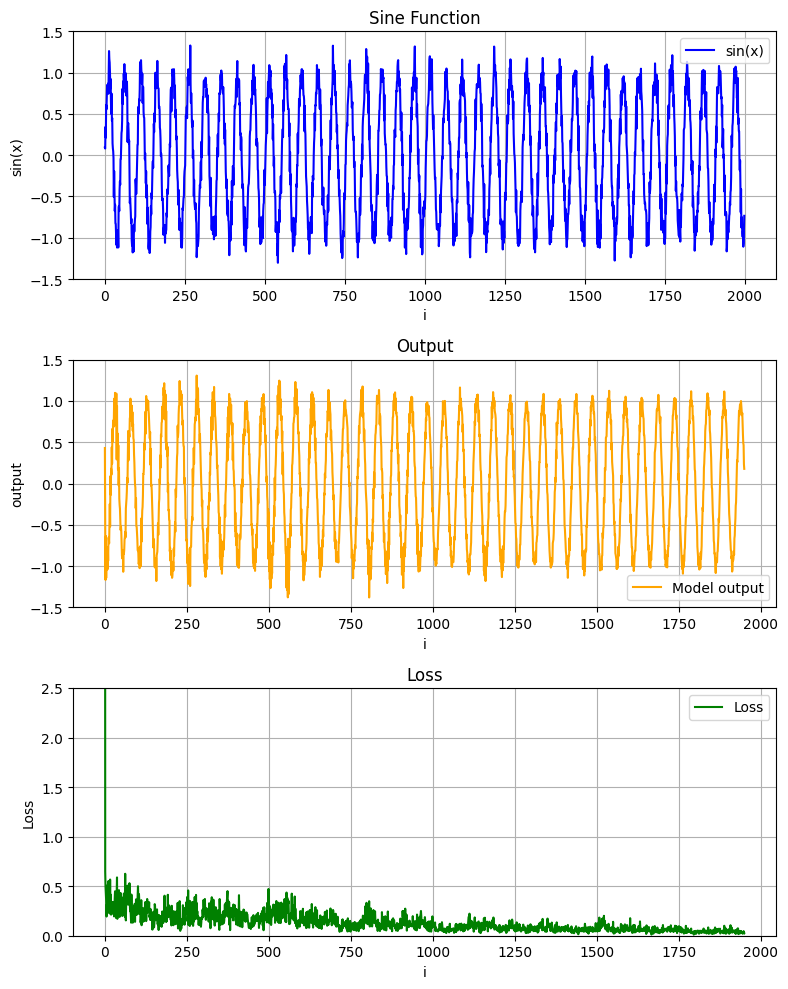

In [133]:
sequence_size = 32
steps = 2000
output_size = 16

b = SSM(sequence_size=sequence_size, hidden_size=64, output_size=output_size)

def create_training_set(samples_per_freq, frequencies, noise_mag = .125):
    s = torch.zeros(1)
    for f in frequencies:
        k = torch.sin(torch.linspace(start=0, end= (samples_per_freq / f), steps=samples_per_freq, dtype=torch.float32))
        s = torch.cat((s,k))
        pass
    return s[1:], torch.randn(samples_per_freq * len(frequencies)) * noise_mag

#sine, noise = create_training_set(100, [32, 50, 75, 8, 20, 66, 12, 88, 15, 42, 22, 46, 79, 13, 77, 99, 40], .1)
#samples = sine + noise
#steps = len(sine)

freq = 8
samples = torch.sin(torch.linspace(start=0, end=steps/freq, steps=steps, dtype=torch.float32)) + torch.randn(steps) * torch.tensor([.125])
sine = torch.sin(torch.linspace(start=0, end=steps/freq, steps=steps, dtype=torch.float32))
optimizer = torch.optim.SGD(b.parameters(), lr = 0.01)
losses = []
output = []
for i in range(steps - (sequence_size + output_size + 1)):
    b.zero_grad()
    x = samples[i: i+ sequence_size]
    y = b(x)
    output.append(y.tolist()[0])
    y = (y - sine[i + sequence_size + 1 : i + sequence_size + output_size + 1]).pow(2).sum(0)
    y.backward()
    losses.append(y.item())
    optimizer.step()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 10))

axs[0].plot(samples.tolist(), color='blue', label='sin(x)')
axs[0].set_title('Sine Function')
axs[0].set_xlabel('i')
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_ylabel('sin(x)')
axs[0].legend()
axs[0].grid()

# Plot the second graph
axs[1].plot(output, color='orange', label='Model output')
axs[1].set_title('Output')
axs[1].set_xlabel('i')
axs[1].set_ylim(-1.5, 1.5)
axs[1].set_ylabel('output')
axs[1].legend()
axs[1].grid()

# Plot the third graph
axs[2].plot(losses, color='green', label='Loss')
axs[2].set_title('Loss')
axs[2].set_xlabel('i')
axs[2].set_ylabel('Loss')
axs[2].set_ylim(0, 2.5)  # Limit y-axis to avoid extreme values
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

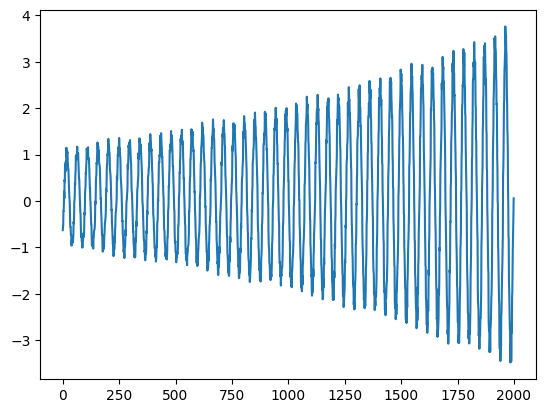

In [137]:

b.reset_hidden()
offset = sequence_size * 5
test_x = samples[offset:sequence_size + offset]
o = []
for i in range(int(steps/output_size)):
    with torch.no_grad():
        y = b(test_x)
        test_x = torch.cat((test_x[output_size:],y))
        for t in y.tolist():
            o.append(t)
plt.plot(o)